# EC7212 – Computer Vision and Image Processing
## Take Home Assignment 2

### Task 1: Otsu's Algorithm with Synthetic Image
### Task 2: Region Growing Segmentation

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Set random seed for reproducibility
np.random.seed(42)

## Task 1: Otsu's Algorithm Implementation

Creating a synthetic image with 2 objects and background (3 pixel values total)

In [18]:
def create_synthetic_image(width=300, height=300):
    """
    Create synthetic image with 2 objects and background
    Background: 50, Object 1: 120, Object 2: 200
    """
    image = np.full((height, width), 50, dtype=np.uint8)  # Background
    
    # Object 1 - Rectangle
    cv2.rectangle(image, (50, 50), (120, 120), 120, -1)
    
    # Object 2 - Circle
    cv2.circle(image, (200, 200), 40, 200, -1)
    
    return image

def add_gaussian_noise(image, mean=0, std=20):
    """
    Add Gaussian noise to the image
    """
    noise = np.random.normal(mean, std, image.shape).astype(np.int16)
    noisy = image.astype(np.int16) + noise
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

# Create synthetic image
synthetic_image = create_synthetic_image()
print(f"Original pixel values: {np.unique(synthetic_image)}")

# Add Gaussian noise
noisy_image = add_gaussian_noise(synthetic_image, std=15)
print(f"Pixel value range after noise: {np.min(noisy_image)} - {np.max(noisy_image)}")

Original pixel values: [ 50 120 200]
Pixel value range after noise: 0 - 252


In [19]:
def otsu_threshold(image):
    """
    Implement Otsu's thresholding algorithm
    """
    # Calculate histogram
    histogram, _ = np.histogram(image.ravel(), bins=256, range=(0, 256))
    total_pixels = image.size
    sum_total = np.dot(np.arange(256), histogram)

    sumB = 0
    wB = 0
    max_between_class_variance = 0
    threshold = 0

    # Find optimal threshold
    for t in range(256):
        wB += histogram[t]  # Weight of background
        if wB == 0:
            continue
        wF = total_pixels - wB  # Weight of foreground
        if wF == 0:
            break

        sumB += t * histogram[t]
        mB = sumB / wB  # Mean of background
        mF = (sum_total - sumB) / wF  # Mean of foreground

        # Between-class variance
        between_class_variance = wB * wF * (mB - mF) ** 2

        if between_class_variance > max_between_class_variance:
            max_between_class_variance = between_class_variance
            threshold = t

    # Apply threshold
    binary_image = (image >= threshold).astype(np.uint8) * 255
    return threshold, binary_image

# Apply Otsu's algorithm
otsu_thresh, otsu_result = otsu_threshold(noisy_image)
print(f"Otsu threshold: {otsu_thresh}")

Otsu threshold: 109


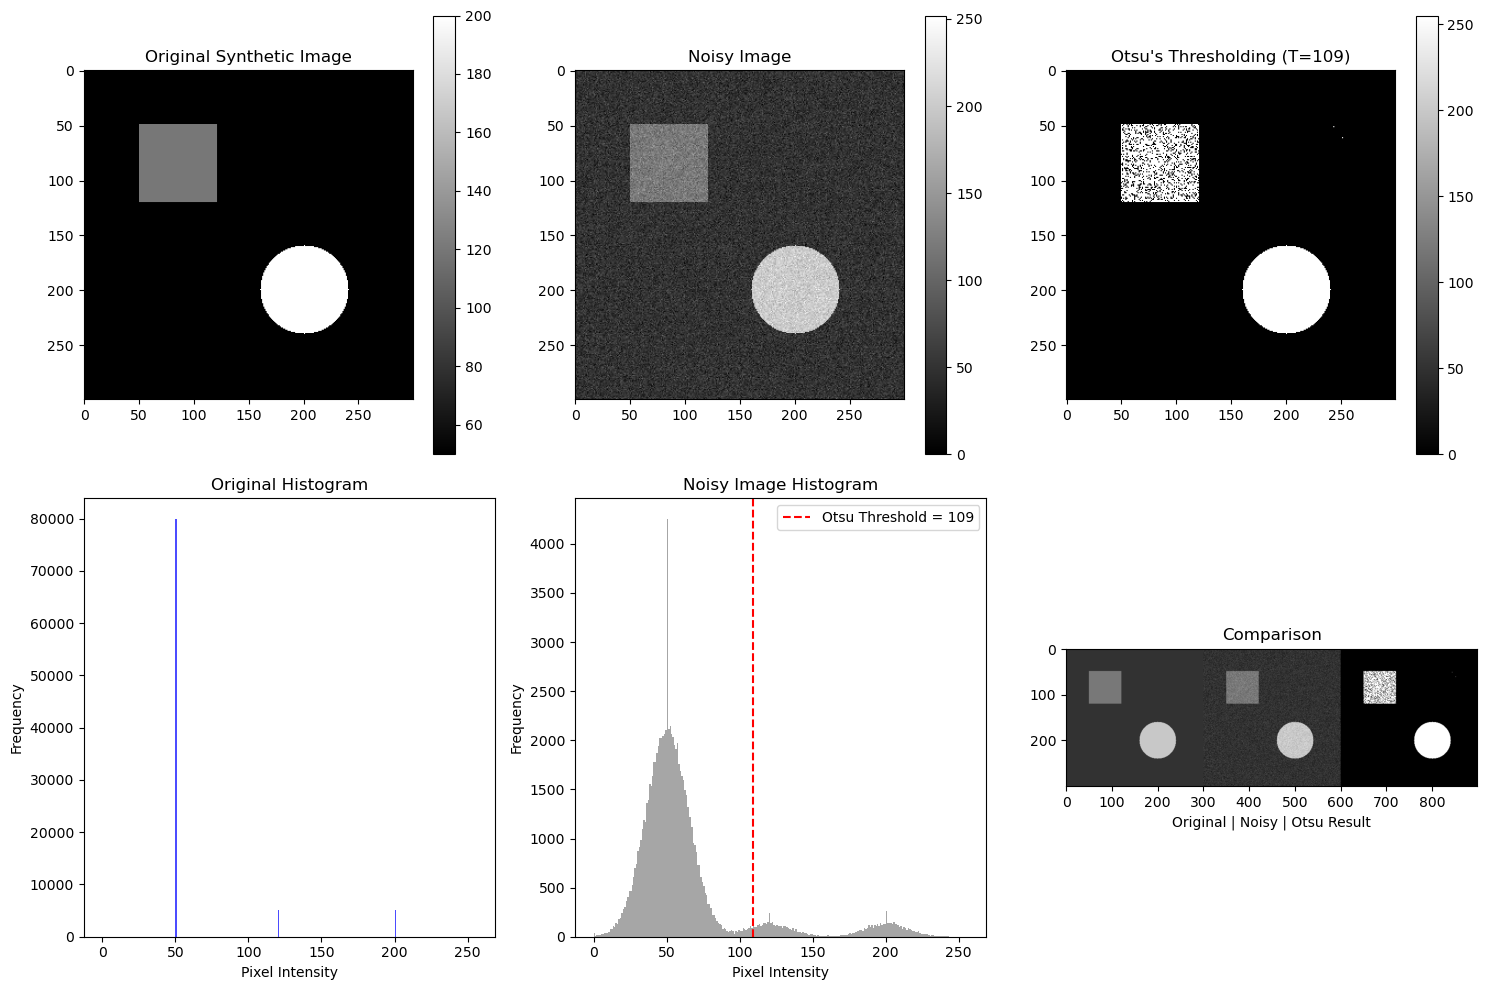

In [20]:
# Display results for Task 1
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.title("Original Synthetic Image")
plt.imshow(synthetic_image, cmap='gray')
plt.colorbar()

plt.subplot(2, 3, 2)
plt.title("Noisy Image")
plt.imshow(noisy_image, cmap='gray')
plt.colorbar()

plt.subplot(2, 3, 3)
plt.title(f"Otsu's Thresholding (T={otsu_thresh})")
plt.imshow(otsu_result, cmap='gray')
plt.colorbar()

plt.subplot(2, 3, 4)
plt.title("Original Histogram")
plt.hist(synthetic_image.ravel(), bins=256, range=(0, 256), alpha=0.7, color='blue')
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.subplot(2, 3, 5)
plt.title("Noisy Image Histogram")
plt.hist(noisy_image.ravel(), bins=256, range=(0, 256), alpha=0.7, color='gray')
plt.axvline(x=otsu_thresh, color='red', linestyle='--', label=f'Otsu Threshold = {otsu_thresh}')
plt.legend()
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.subplot(2, 3, 6)
plt.title("Comparison")
plt.imshow(np.hstack([synthetic_image, noisy_image, otsu_result]), cmap='gray')
plt.xlabel("Original | Noisy | Otsu Result")

plt.tight_layout()
plt.show()

## Task 2: Region Growing Segmentation

Loading image from the image folder and implementing region growing

In [21]:
def load_image_from_folder():
    """
    Load image from the image folder
    """
    image_folder = "../image"
    
    # Try common image file extensions
    extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    
    if os.path.exists(image_folder):
        for file in os.listdir(image_folder):
            if any(file.lower().endswith(ext) for ext in extensions):
                image_path = os.path.join(image_folder, file)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    print(f"Loaded image: {file}")
                    return image, file
    
    # If no image found in folder, use the synthetic image
    print("No image found in folder, using synthetic image for region growing")
    return noisy_image, "synthetic_noisy_image"

# Load image for region growing
region_image, image_name = load_image_from_folder()
print(f"Image shape: {region_image.shape}")

No image found in folder, using synthetic image for region growing
Image shape: (300, 300)


In [22]:
def region_growing(image, seeds, threshold=10):
    """
    Region growing algorithm for image segmentation
    
    Args:
        image: Input grayscale image
        seeds: List of seed points [(x, y), ...]
        threshold: Similarity threshold
    
    Returns:
        segmented: Binary segmentation mask
    """
    height, width = image.shape
    segmented = np.zeros_like(image, dtype=np.uint8)
    visited = np.zeros_like(image, dtype=bool)

    # Initialize queue with seed points
    queue = list(seeds)
    
    # Calculate mean value of seed points
    seed_values = [image[y, x] for x, y in seeds]
    mean_value = np.mean(seed_values)
    print(f"Seed values: {seed_values}")
    print(f"Mean seed value: {mean_value:.2f}")

    # 8-connectivity neighbors
    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

    while queue:
        x, y = queue.pop(0)
        
        if visited[y, x]:
            continue
            
        visited[y, x] = True
        current_value = image[y, x]
        
        # Check if pixel is similar to seed region
        if abs(int(current_value) - int(mean_value)) <= threshold:
            segmented[y, x] = 255

            # Add neighboring pixels to queue
            for dx, dy in neighbors:
                nx, ny = x + dx, y + dy
                if (0 <= nx < width) and (0 <= ny < height) and not visited[ny, nx]:
                    queue.append((nx, ny))

    return segmented

def select_seed_points(image):
    """
    Automatically select seed points based on image content
    """
    height, width = image.shape
    
    # For synthetic image, select points from objects
    if image.shape == (300, 300):
        seeds = [(85, 85), (200, 200)]  # Centers of objects
    else:
        # For other images, select points from different regions
        seeds = [
            (width//4, height//4),
            (3*width//4, height//4),
            (width//2, height//2),
            (width//4, 3*height//4)
        ]
    
    return seeds

# Select seed points
seed_points = select_seed_points(region_image)
print(f"Selected seed points: {seed_points}")

# Apply region growing with different thresholds
thresholds = [5, 15, 25]
segmentation_results = []

for thresh in thresholds:
    segmented_mask = region_growing(region_image, seed_points, threshold=thresh)
    segmentation_results.append((thresh, segmented_mask))
    print(f"Threshold {thresh}: {np.sum(segmented_mask > 0)} pixels segmented")

Selected seed points: [(85, 85), (200, 200)]
Seed values: [117, 196]
Mean seed value: 156.50
Threshold 5: 0 pixels segmented
Seed values: [117, 196]
Mean seed value: 156.50
Threshold 15: 0 pixels segmented
Seed values: [117, 196]
Mean seed value: 156.50
Threshold 25: 0 pixels segmented


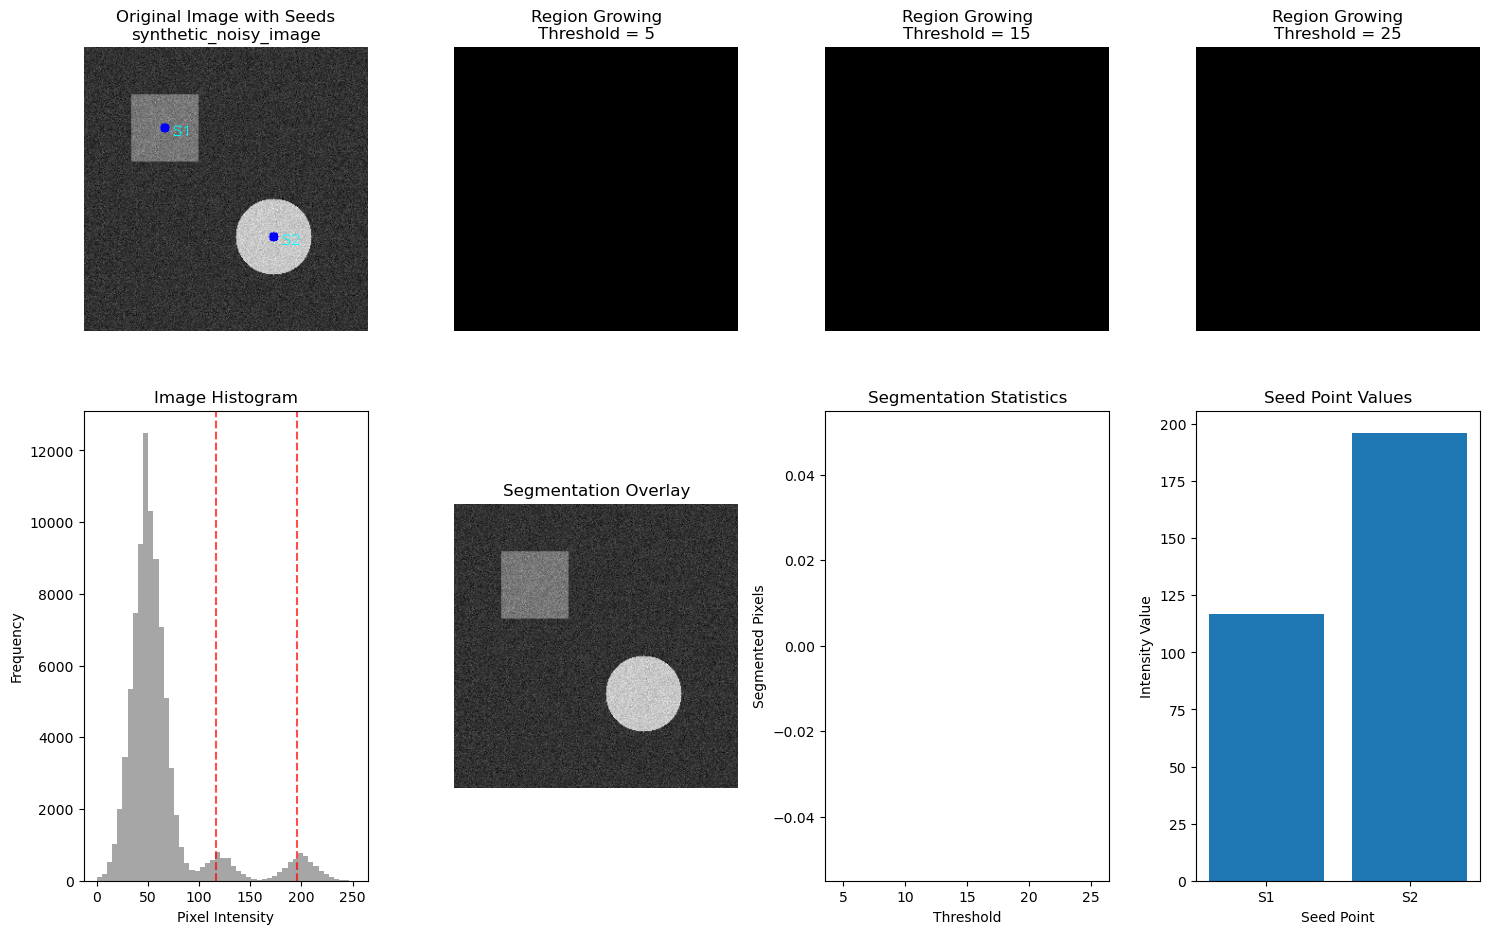

In [23]:
# Display results for Task 2
plt.figure(figsize=(15, 10))

# Original image with seed points
image_with_seeds = cv2.cvtColor(region_image, cv2.COLOR_GRAY2BGR)
for i, (x, y) in enumerate(seed_points):
    cv2.circle(image_with_seeds, (x, y), radius=5, color=(255, 0, 0), thickness=-1)
    cv2.putText(image_with_seeds, f'S{i+1}', (x+8, y+8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

plt.subplot(2, 4, 1)
plt.title(f"Original Image with Seeds\n{image_name}")
plt.imshow(cv2.cvtColor(image_with_seeds, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Display segmentation results for different thresholds
for i, (thresh, segmented) in enumerate(segmentation_results):
    plt.subplot(2, 4, i+2)
    plt.title(f"Region Growing\nThreshold = {thresh}")
    plt.imshow(segmented, cmap='gray')
    plt.axis('off')

# Show histogram
plt.subplot(2, 4, 5)
plt.title("Image Histogram")
plt.hist(region_image.ravel(), bins=50, alpha=0.7, color='gray')
seed_values = [region_image[y, x] for x, y in seed_points]
for val in seed_values:
    plt.axvline(x=val, color='red', linestyle='--', alpha=0.7)
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

# Overlay segmentation on original
best_segmentation = segmentation_results[1][1]  # Use middle threshold
overlay = cv2.cvtColor(region_image, cv2.COLOR_GRAY2BGR)
overlay[best_segmentation > 0] = [0, 255, 0]  # Green overlay

plt.subplot(2, 4, 6)
plt.title("Segmentation Overlay")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Statistics
plt.subplot(2, 4, 7)
plt.title("Segmentation Statistics")
thresh_values = [r[0] for r in segmentation_results]
pixel_counts = [np.sum(r[1] > 0) for r in segmentation_results]
plt.bar(thresh_values, pixel_counts)
plt.xlabel("Threshold")
plt.ylabel("Segmented Pixels")

plt.subplot(2, 4, 8)
plt.title("Seed Point Values")
seed_intensities = [region_image[y, x] for x, y in seed_points]
plt.bar(range(len(seed_intensities)), seed_intensities)
plt.xlabel("Seed Point")
plt.ylabel("Intensity Value")
plt.xticks(range(len(seed_intensities)), [f'S{i+1}' for i in range(len(seed_intensities))])

plt.tight_layout()
plt.show()

## Results Summary

In [24]:
print("=" * 50)
print("ASSIGNMENT 2 RESULTS SUMMARY")
print("=" * 50)

print("\nTask 1: Otsu's Algorithm")
print(f"- Original image pixel values: {np.unique(synthetic_image)}")
print(f"- Gaussian noise std: 15")
print(f"- Otsu threshold: {otsu_thresh}")
print(f"- Binary segmentation accuracy: {np.sum(otsu_result > 0)} foreground pixels")

print("\nTask 2: Region Growing")
print(f"- Image used: {image_name}")
print(f"- Image dimensions: {region_image.shape}")
print(f"- Number of seed points: {len(seed_points)}")
print(f"- Seed locations: {seed_points}")
print(f"- Seed intensities: {[region_image[y, x] for x, y in seed_points]}")

print("\nRegion Growing Results:")
for thresh, segmented in segmentation_results:
    segmented_pixels = np.sum(segmented > 0)
    percentage = (segmented_pixels / region_image.size) * 100
    print(f"- Threshold {thresh}: {segmented_pixels} pixels ({percentage:.1f}% of image)")

print("\nAll tasks completed successfully!")
print("Results are displayed in the plots above.")

ASSIGNMENT 2 RESULTS SUMMARY

Task 1: Otsu's Algorithm
- Original image pixel values: [ 50 120 200]
- Gaussian noise std: 15
- Otsu threshold: 109
- Binary segmentation accuracy: 8960 foreground pixels

Task 2: Region Growing
- Image used: synthetic_noisy_image
- Image dimensions: (300, 300)
- Number of seed points: 2
- Seed locations: [(85, 85), (200, 200)]
- Seed intensities: [117, 196]

Region Growing Results:
- Threshold 5: 0 pixels (0.0% of image)
- Threshold 15: 0 pixels (0.0% of image)
- Threshold 25: 0 pixels (0.0% of image)

All tasks completed successfully!
Results are displayed in the plots above.
